In [32]:
# This is my implementation of Lanczos to approximate the SVD. I will be doing this to view MNIST images via PCA

In [33]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from keras.datasets import mnist
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA

In [34]:
def lanczos(A, k):
    r = A.shape[0]
    V = np.zeros((r,k))
    alphas = np.zeros(k)
    betas = np.zeros(k)
    v = np.random.rand(r)
    v = v/np.linalg.norm(v)
    b = 0
    v_previous = np.zeros(r).T
    for i in range(k):
        V[:,i] = v
        w = A.dot(v)
        a = np.dot(v, w)
        alphas[i] = a
        w = w - b*v_previous - a*v
        
        # Possible re-orthogonalization (serial)
        for t in range(i):
            adj = np.dot(V[:, t], w)
            if adj == 0.0:
                continue
            w -= adj * V[:, t]
        
        b = np.linalg.norm(w)
        betas[i] = b
        if b < np.finfo(float).eps:
            break
        v_previous = v
        v = (1/b)*w
    
    T = np.diag(alphas) + np.diag(betas[0:-1], k=1) + np.diag(betas[0:-1], k=-1)
    return T, V

In [35]:
def approx_svd(T, V, m, c):
    # Compute Eigenvalues and Eigenvectors of Tridiagonal Matrix from Lanczos
    Eig_val, Eig_vec = np.linalg.eigh(T)
    tempY = V@Eig_vec
    r = tempY.shape[0]
    Y_l = tempY[-m:, -c:]/np.linalg.norm(tempY[-m:, -c:], axis=0, keepdims=True)
    Y_r = tempY[0:r-m, -c:]/np.linalg.norm(tempY[0:r-m, -c:], axis=0, keepdims=True)
    return np.fliplr(Y_l), Eig_val, np.fliplr(Y_r)

In [36]:
def sym_data(X):
    # Create symmetric matrix S
    r,c = X.shape
    S = np.zeros((r+c, r+c))
    S[0:c, c:r+c] = X.T
    S[c:r+c, 0:c] = X
    return S

In [37]:
# Perform PCA on MNIST using Lanczos for a specific k
(train_X, train_y), (test_X, test_y) = mnist.load_data()
train_samples = train_X.shape[0]
test_samples = test_X.shape[0]
pixels = train_X.shape[1]*train_X.shape[2]
X = train_X.reshape(train_samples, pixels)

# for less space
#X = test_X.reshape(test_samples,pixels)
#labels = test_y.reshape(len(test_y),1)

# Even Smaller (to test appx SVD)
num = 20000
X = X[0:num,:]
labels = train_y[0:num].reshape(num,1)
m, n = X.shape

#standardize data
X = StandardScaler().fit_transform(X)

# Create symmetric version of data
S = sym_data(X)

In [38]:
# 3D PCA Computations (Will use for 2D as well)
k = 60
appx = 3
t3d = time.time()
T, V = lanczos(S, k)
U, D, Vt = approx_svd(T, V, m, appx)
elapsed_t3d = time.time() - t3d
proj_X = X@Vt
data = np.append(proj_X, labels, axis = 1)
df = pd.DataFrame(data, columns=["x", "y", "z", "Digit"])
df.sort_values('Digit', axis=0, ascending=True, inplace=True)
df["Digit"] = df["Digit"].astype(str)

In [39]:
# 3D PCA Plot
fig = px.scatter_3d(df, x = "x", y = "y", z = "z", color = "Digit")
fig.update_traces(mode='markers', marker_size=2.5)
fig.show()

In [40]:
# 2D PCA Plot
fig = px.scatter(df, x = "x", y = "y", color = "Digit")
fig.update_traces(mode='markers', marker_size=3)
fig.show()

In [41]:
# Time the difference between computing true SVD and approximate SVD via Lanczos
tsvd = time.time()
Ux, Sx, Vx = np.linalg.svd(X)
elapsed_tsvd = time.time() - tsvd

In [42]:
# Compare the differences in runtime
print('Computational Time for Approximate SVD via Lanczos:')
print(elapsed_t3d)
print('Computational Time for True SVD:')
print(elapsed_tsvd)

Computational Time for Approximate SVD via Lanczos:
32.747642278671265
Computational Time for True SVD:
160.38883781433105


In [43]:
# Compare values of k (to determine how varying k affects accuracy)
k_vals = np.linspace(0,150, 16).astype(int)
k_vals[0] = 1

times = np.zeros((k_vals.shape[0],1))
errors_inf = np.zeros((k_vals.shape[0],1))
errors_2norm = np.zeros((k_vals.shape[0],1))
dim = 3

count = 0
for k in k_vals:
    t3dk = time.time()
    Tk, Vk = lanczos(S, k)
    Uk, Dk, Vk = approx_svd(Tk, Vk, m, dim)
    elapsed_t3dk = time.time() - t3dk
    print('Run for k = %d is Complete!' %k)
    times[count] = elapsed_t3dk
    errors_inf[count] = np.linalg.norm(abs(Vk) - abs(Vx.T[:,0:dim]), np.inf)
    errors_2norm[count] = np.linalg.norm(abs(Vk) - abs(Vx.T[:,0:dim]))
    count += 1

Run for k = 1 is Complete!
Run for k = 10 is Complete!
Run for k = 20 is Complete!
Run for k = 30 is Complete!
Run for k = 40 is Complete!
Run for k = 50 is Complete!
Run for k = 60 is Complete!


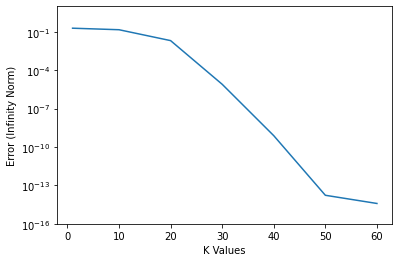

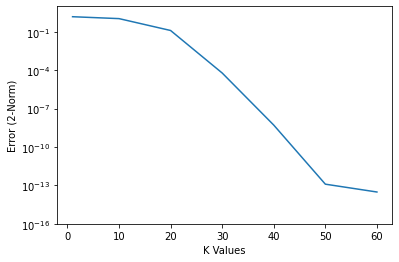

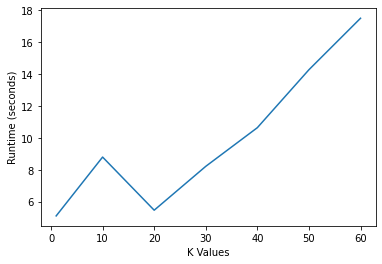

In [44]:
fig1 = plt.figure()
plt.plot(k_vals, errors_inf)
plt.xlabel('K Values')
plt.ylabel('Error (Infinity Norm)')
plt.yscale('log')
plt.ylim([1e-16, 10])
plt.show()

fig2 = plt.figure()
plt.plot(k_vals, errors_2norm)
plt.xlabel('K Values')
plt.ylabel('Error (2-Norm)')
plt.yscale('log')
plt.ylim([1e-16, 10])
plt.show()

fig3 = plt.figure()
plt.plot(k_vals, times)
plt.xlabel('K Values')
plt.ylabel('Runtime (seconds)')
plt.show()

In [45]:
tpca = time.time()
pca = PCA(n_components=3)
pca.fit(X)
X2 = pca.transform(X)
elapsed_pca = time.time() - tpca

print(elapsed_pca)


2.8929202556610107


In [46]:
num = 5000
mean = [0, 0, 0]
cov = [[20, 0, 0], [0, 100, 0], [0, 0, 50]] 
X_mvg = np.random.multivariate_normal(mean, cov, num)
noise = np.random.rand(num,20)
X_mvg_noise = np.hstack((X_mvg,noise))

In [47]:
df = pd.DataFrame(X_mvg, columns=["x", "y", "z"])
fig = px.scatter_3d(df, x = "x", y = "y", z = "z")
fig.update_traces(mode='markers', marker_size=2.5)
fig.update_layout(
    scene = dict(
        xaxis = dict(nticks=4, range=[-30,30],),
                     yaxis = dict(nticks=4, range=[-30,30],),
                     zaxis = dict(nticks=4, range=[-30,30],),),
    width=700,
    margin=dict(r=20, l=10, b=10, t=10))

fig.show()

In [48]:
Ug,Dg,Vg = np.linalg.svd(X_mvg_noise)
X_reconstruct = X_mvg_noise@Vg[:,0:3]
df = pd.DataFrame(X_reconstruct, columns=["x", "y", "z"])

In [49]:
k = 10
appx = 3
Smvg = sym_data(X_mvg_noise)
Tmvg, Vmvg = lanczos(Smvg, k)
Umvg, Dmvg, Vmvg = approx_svd(Tmvg, Vmvg, X_mvg_noise.shape[0], appx)
X_lanczos_rec = X_mvg_noise@Vmvg
df = pd.DataFrame(X_lanczos_rec, columns=["x", "y", "z"])

In [50]:
fig = px.scatter_3d(df, x = "x", y = "y", z = "z")
fig.update_traces(mode='markers', marker_size=2.5)
fig.update_layout(
    scene = dict(
        xaxis = dict(nticks=4, range=[-30,30],),
                     yaxis = dict(nticks=4, range=[-30,30],),
                     zaxis = dict(nticks=4, range=[-30,30],),),
    width=700,
    margin=dict(r=20, l=10, b=10, t=10))
fig.show()

In [51]:
# Test
#num = 60
#A = np.random.rand(num,20)*2
#H = sym_data(A)
#T, V = lanczos(H, 30)

#Yl, D, Yr = approx_svd(T, V, num, 2)

#U,D2,Vh = np.linalg.svd(A)

#print('============')
#print(Yr[0:10,:])
#print('============')
#print(Vh.T[0:10,0:2])

#print('============')
#print(Yl[0:10,:])
#print('============')
#print(U[0:10,0:2])